In [25]:
import re
import string
from collections import defaultdict
import pickle
from tqdm import tqdm
from unidecode import unidecode
import matplotlib.pyplot as plt
from collections import Counter


In [3]:
#Loại bỏ các dấu câu
def remove_punctuation(text):
  return "".join([char for char in text if char not in string.punctuation])

In [4]:
sentence = "Kiểm tra thử loại bỏ các dấu câu!!! Ngày mai, trời lại sáng"
remove_punctuation(sentence)

'Kiểm tra thử loại bỏ các dấu câu Ngày mai trời lại sáng'

In [5]:
def remove_punctuation_corpus(corpus):
  corpus_process = []
  for sentence in tqdm(corpus):
    corpus_process.append(remove_punctuation(sentence))
  return corpus_process

In [6]:
def remove_diacritic(text):
    """Hàm loại bỏ dấu tiếng Việt"""
    DIACRITIC_MAP = {
        "áàảãạăắằẳẵặâấầẩẫậ": "a",
        "ÁÀẢÃẠĂẮẰẲẴẶÂẤẦẨẪẬ": "A",
        "éèẻẽẹêếềểễệ": "e",
        "ÉÈẺẼẸÊẾỀỂỄỆ": "E",
        "íìỉĩị": "i",
        "ÍÌỈĨỊ": "I",
        "óòỏõọôốồổỗộơớờởỡợ": "o",
        "ÓÒỎÕỌÔỐỒỔỖỘƠỚỜỞỠỢ": "O",
        "úùủũụưứừửữự": "u",
        "ÚÙỦŨỤƯỨỪỬỮỰ": "U",
        "ýỳỷỹỵ": "y",
        "ÝỲỶỸỴ": "Y",
        "đ": "d",
        "Đ": "D",
    }
    for accents, char in DIACRITIC_MAP.items():
        text = re.sub(f"[{accents}]", char, text)
    return text

In [9]:
file_path = 'train_ipt_500k.pkl'
with open(file_path, 'rb') as f:
    train_ipt_500k = pickle.load(f)

In [10]:
train_dataset = train_ipt_500k[:7777]
corpus_process = remove_punctuation_corpus(train_dataset)
print(corpus_process[:10])


100%|██████████| 7777/7777 [00:00<00:00, 33234.81it/s]

['Trang Chính\n', 'Internet Society\n', 'Internet Society hay ISOC là một tổ chức quốc tế hoạt động phi lợi nhuận phi chính phủ và bao gồm các thành viên có trình độ chuyên ngành Tổ chức này chú trọng đến tiêu chuẩn giáo dục và các vấn đề về chính sách Với trên 145 tổ chức thành viên và 65000 thành viên cá nhân ISOC bao gồm những con người cụ thể trong cộng đồng Internet Mọi chi tiết có thể tìm thấy tại website của ISOC\n', 'Internet Society nằm ở gần thủ đô Washington DC Hoa Kỳ và Geneva Thụy Sĩ Số hội viên của nó bao gồm hơn 145 tổ chức thành viên và hơn 65000 cá nhân Thành viên còn có thể tự lập một chi nhánh của tổ chức tùy theo vị trí hoặc sở thích Hiện nay tổ chức có tới 90 chi nhánh trên toàn thế giới\n', 'Bảo đảm cổ vũ cho sự phát triển mở rộng và sử dụng Internet được thuận lợi nhất cho mọi người trên toàn thế giới\n', 'Tiếng Việt\n', 'Tiếng Việt được chính thức ghi nhận trong Hiến pháp nước Cộng hòa xã hội chủ nghĩa Việt Nam 2013 tại Chương I Điều 5 Mục 3 là ngôn ngữ quốc gia

In [47]:
train_dataset = train_ipt_500k[:7777]


In [39]:
train_dataset_length = [len(sentence) for sentence in train_dataset]
lengths_counts = Counter(train_dataset_length)

In [40]:
print(f"Độ dài trung bình của các câu: {sum(train_dataset_length) / len(train_dataset)}")
print(f"Độ dài câu dài nhất: {max(train_dataset_length)}")
print(f"Độ dài câu ngắn nhất: {min(train_dataset_length)}")
most_common_length, frequency_max = lengths_counts.most_common(1)[0]
print(f"Độ dài câu xuất hiện nhiều nhất: {frequency_max}")
least_common_length, frequency_min = lengths_counts.most_common()[-1]
print(f"Độ dài câu xuất hiện ít nhất: {frequency_min}")

Độ dài trung bình của các câu: 433.95473833097594
Độ dài câu dài nhất: 2654
Độ dài câu ngắn nhất: 2
Độ dài câu xuất hiện nhiều nhất: 37
Độ dài câu xuất hiện ít nhất: 1


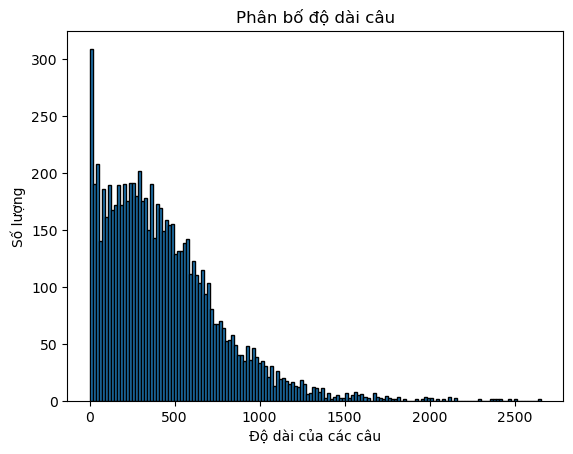

In [41]:
plt.hist(train_dataset_length, bins = 150, edgecolor = "black")
plt.title("Phân bố độ dài câu")
plt.xlabel("Độ dài của các câu")
plt.ylabel("Số lượng")
plt.show()

In [43]:
train_dataset_new = [train_dataset[i] for i in range(len(train_dataset)) if len(train_dataset[i]) < 500]
print(f"Số phần tử của tập dữ liệu: {len(train_dataset)}")
train_dataset_length_new = [len(sentence) for sentence in train_dataset_new]

Số phần tử của tập dữ liệu: 7777


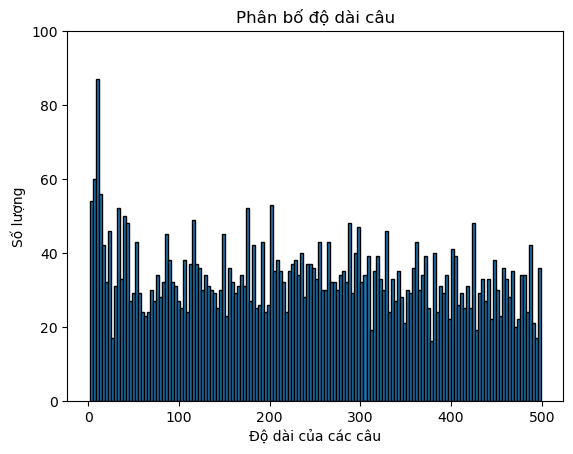

In [46]:
plt.hist(train_dataset_length_new, bins = 150, edgecolor = "black")
plt.title("Phân bố độ dài câu")
plt.xlabel("Độ dài của các câu")
plt.ylabel("Số lượng")
plt.ylim(0, 100)
plt.show()

In [48]:
corpus_process = remove_punctuation_corpus(train_dataset_new)
print(corpus_process[:10])

100%|██████████| 5026/5026 [00:00<00:00, 57850.09it/s]

['Trang Chính\n', 'Internet Society\n', 'Internet Society hay ISOC là một tổ chức quốc tế hoạt động phi lợi nhuận phi chính phủ và bao gồm các thành viên có trình độ chuyên ngành Tổ chức này chú trọng đến tiêu chuẩn giáo dục và các vấn đề về chính sách Với trên 145 tổ chức thành viên và 65000 thành viên cá nhân ISOC bao gồm những con người cụ thể trong cộng đồng Internet Mọi chi tiết có thể tìm thấy tại website của ISOC\n', 'Internet Society nằm ở gần thủ đô Washington DC Hoa Kỳ và Geneva Thụy Sĩ Số hội viên của nó bao gồm hơn 145 tổ chức thành viên và hơn 65000 cá nhân Thành viên còn có thể tự lập một chi nhánh của tổ chức tùy theo vị trí hoặc sở thích Hiện nay tổ chức có tới 90 chi nhánh trên toàn thế giới\n', 'Bảo đảm cổ vũ cho sự phát triển mở rộng và sử dụng Internet được thuận lợi nhất cho mọi người trên toàn thế giới\n', 'Tiếng Việt\n', 'Tiếng Việt cũng đã được công nhận là một ngôn ngữ dân tộc thiểu số tại Cộng hòa Séc\n', 'Tổ chức tiêu chuẩn hóa quốc tế đặt mã ngôn ngữ hai chữ

###    **start_prob:** Xác suất để 1 từ là bắt đầu của một câu

    P(s) = (số lần câu bắt đầu bởi từ s) / (tổng số câu)
###   **trans_prob:** Xác suất để một từ xuất hiện sau một từ
    
    P(xt = s' | xt-1 = s) = (Số lần xuất hiện của cặp từ ss') / (Số lần xuất hiện của từ s)

### **emit_prob:** Xác suất phát sinh, xác suất để 1 từ có có dấu tương ứng với từ có dấu

    P(x = o | y = s) = (số lần từ không dấu s tương ứng từ có dấu o) / (Số lượng từ không dấu s)

In [12]:
def compute_probabilities(dataset):
  start_count = defaultdict(int)
  trans_count = defaultdict(lambda: defaultdict(int))
  emit_count = defaultdict(lambda: defaultdict(int))
  for sentence in tqdm(dataset):
    words = sentence.split()
    prev_word = None
    for idx, word in enumerate(words):
      no_diacritic = remove_diacritic(word)
      emit_count[no_diacritic][word] += 1
      if idx == 0:
        start_count[word] += 1
      else:
        trans_count[prev_word][word] += 1
      prev_word = word
    start_prob = {k : v / sum(start_count.values()) for k, v in start_count.items()}
    trans_prob = {k : {k2 : v2 / sum(v.values()) for k2, v2 in v.items()} for k, v in trans_count.items()}
    emit_prob =  {k : {k2 : v2 / sum(v.values()) for k2, v2 in v.items()} for k, v in emit_count.items()}
  return start_count, trans_count , emit_count

In [13]:
def beam_search(obs, states, start_prob, trans_prob, emit_prob, beam_width = 5):
  T = len(obs)
  dp = [{} for _ in range(T)]
  path = {}

  for state in states.get(obs[0], [obs[0]]):
    dp[0][state] = start_prob.get(state, 1e-6) * emit_prob.get(state, {}).get(obs[0], 1e-6)
    path[state] = [state]

  for t in range(1, T):
    new_path = {}

    candidates = []
    for current_state in states.get(obs[t], [obs[t]]):
      for prev_state in dp[t - 1]:
        prob = dp[t - 1][prev_state] * trans_prob.get(prev_state, {}).get(current_state, 1e-6) * emit_prob.get(current_state, {}).get(obs[t], 1e-6)
        candidates.append((prob, prev_state, current_state))

    candidates.sort(reverse=True, key=lambda x: x[0])
    candidates = candidates[:beam_width]
    for prob, prev_state, current_state in candidates:
      dp[t][current_state] = prob
      if current_state not in new_path:
        new_path[current_state] = path[prev_state] + [current_state]
    path = new_path
  (prob, best_final_state) = max((dp[T - 1][state], state) for state in dp[T - 1])
  return path[best_final_state]


In [49]:
start_prob, trans_prob, emit_prob = compute_probabilities(corpus_process)
states = defaultdict(list)
for word in emit_prob:
    states[remove_diacritic(word)].extend(emit_prob[word].keys())

100%|██████████| 5026/5026 [05:13<00:00, 16.03it/s]


In [52]:
obs = "la mot to chuc hoat dong phi loi nhuan"
result = beam_search(obs.split(" "), states, start_prob, trans_prob, emit_prob)
print("Chuỗi có dấu:", " ".join(result))

Chuỗi có dấu: là một tổ chức hoạt động phi lợi nhuận
